# Analysis of different latent spaces for the autoencoder model
We use as the input data images from the first 2 months of 2016 because of the number of times we will have to train and evaluate our model

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import sunpy.map
import cv2
import skimage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import glob

import autoenc_model as aem

2023-03-15 13:26:36.325421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading data and removing noise

In [2]:
# Read images
image_files = glob.glob("data/aia_193A/2016-01*.fits")
image_files = image_files + glob.glob("data/aia_193A/2016-01*.fits")

with open("noisy_193A.csv", "r") as f:
    noise_imgs = f.readlines()

image_files = [i for i in image_files if i not in noise_imgs]

AIA193_2016 = sunpy.map.Map(image_files)
AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))


# Normalize images
min_values = AIA193_2016_matrix.min(axis=2).min(axis=1)
max_values = AIA193_2016_matrix.max(axis=2).max(axis=1)

rg = max_values - min_values
rg = np.fmax(rg, 1e-4*np.ones(rg.shape)).reshape([-1,1,1])

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values.reshape([-1,1,1])) / rg


input_train, input_test = train_test_split(AIA193_2016_mnorm, test_size=0.2)
print(f"number of images used: {len(AIA193_2016_mnorm)}")
print(f"for training: {len(input_train)}")
print(f"for testing: {len(input_test)}")

number of images used: 486
for training: 388
for testing: 98


## Train and discard autoencoders with different latent space sizes

In [3]:
latent_size = 64
n_epochs = 200
batch_size = 128

k_search = np.concatenate([np.arange(1, 16, 2), np.arange(16, 64, 4), np.arange(64, 256, 16), np.arange(256, 1024, 32), [1024]])

for i in range(1,8):
    mse_values = []
    for k in k_search:
        print(f"\nStarting training for k={k}")
        autoencoder, _, _ = aem.gen_xception_autoenc_3c(k, optim="adam", loss="mse", verbose=False)
        autoencoder.fit(input_train.reshape([-1, 256,256,1]), input_train.reshape([-1, 256,256,1]), validation_split=0.2, epochs=n_epochs, batch_size=batch_size, verbose=False)

        print(f"Finished training for k={k}")

        mse_value = autoencoder.evaluate(input_test.reshape([-1, 256,256,1]), input_test.reshape([-1, 256,256,1]))[0]
        mse_value_array = np.array(mse_value)
        mse_values.append(mse_value)

        del autoencoder
        del mse_value

    pd.DataFrame({"Latent":k_search, "MSE":mse_values}).to_csv(f"knee_AE{i}.csv", index=False)


Starting training for k=1


2023-03-15 13:26:45.682617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 13:26:45.695362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 13:26:45.695526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 13:26:45.696051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

Finished training for k=1
4/4 [==============================] - 1s 62ms/step - loss: 0.0034 - mae: 0.0359

Starting training for k=3
Finished training for k=3
4/4 [==============================] - 0s 7ms/step - loss: 0.0035 - mae: 0.0316

Starting training for k=5
Finished training for k=5
4/4 [==============================] - 0s 6ms/step - loss: 0.0033 - mae: 0.0288

Starting training for k=7
Finished training for k=7
4/4 [==============================] - 0s 7ms/step - loss: 0.0031 - mae: 0.0271

Starting training for k=9
Finished training for k=9
4/4 [==============================] - 0s 6ms/step - loss: 0.0194 - mae: 0.0908

Starting training for k=11
Finished training for k=11
4/4 [==============================] - 0s 6ms/step - loss: 0.0026 - mae: 0.0271

Starting training for k=13
Finished training for k=13
4/4 [==============================] - 0s 6ms/step - loss: 0.0033 - mae: 0.0284

Starting training for k=15
Finished training for k=15
4/4 [==============================]

KeyboardInterrupt: 

## Get graph

In [10]:
collected_data_files = [
    "knee_AE0.csv",
    "knee_AE1.csv",
    "knee_AE2.csv",
    "knee_AE3.csv"
]


collected_data = pd.read_csv("knee_AE0.csv")
#collected_data = collected_data.drop(columns=["MSE"])
# collected_data = pd.DataFrame(columns=["Latent", "MSE", "exec"])
for idx, data_file in enumerate(collected_data_files):
    df = pd.read_csv(data_file)
    df["exec"] = idx
    #collected_data = pd.concat([collected_data, df])
    collected_data["MSE"] = np.fmin(collected_data["MSE"], df["MSE"])

collected_data

,Latent,MSE
0,1,0.003127
1,3,0.003180
2,5,0.002954
3,7,0.003053
4,9,0.003594
5,11,0.002556
6,13,0.002717
7,15,0.002645
8,16,0.002400
9,20,0.002705


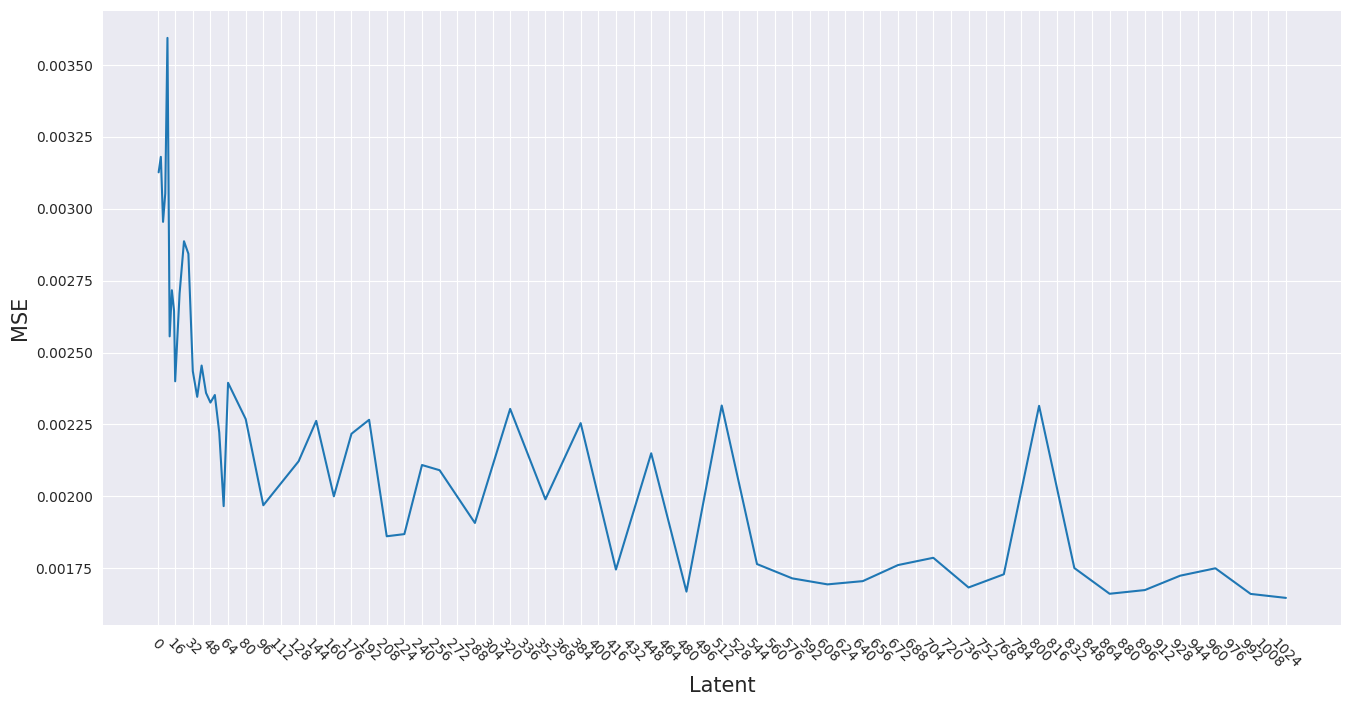

In [11]:
fig, axes = plt.subplots(1, figsize=(16,8)) 

sns.lineplot(collected_data, x="Latent", y="MSE").set(xticks=range(0,1024+16,16))
axes.set_xticklabels(axes.get_xticklabels(), rotation=-45)
plt.show()